# Intursion Detection in Internet of Vehicles

# Proposed model name : Leader Class and Confidence Decision Ensemble (LCCDE)

This code is based on the research paper accepted in 2022 IEEE Global Communications Conference (GLOBECOM).
Authors of this research paper are Li Yang , Abdallah Shami,Gary Stevens ,and Stephen de Rusett.
Link to the research : https://ieeexplore.ieee.org/abstract/document/10001280

## Import libraries

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

## Read the sampled CICIDS2017 dataset
The Dataset used to train as well as test the model is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html .Due to the large size of this dataset,we have used sample subsets of CICIDS2017.

In [32]:
df = pd.read_csv("./data/CICIDS2017_sample_km.csv")

In [33]:
df.head(5)

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1.806901,0.054600,0.008402,-0.017446,0.057771,0.280437,-0.211174,-0.018124,0.268892,1.528310,...,-1.023413,-0.108552,-0.081786,-0.127566,-0.093413,2.179587,-0.137651,2.102110,2.215333,3
1,-0.527638,-0.086001,-0.066771,-0.032526,-0.047410,-0.191864,0.582875,-0.029612,-0.255104,-0.522948,...,0.742115,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,0
2,-0.483067,-0.050851,-0.021667,-0.033088,0.057881,-0.218767,-0.211174,-0.198110,-0.209439,3.620304,...,-1.023413,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,3
3,-0.361387,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-1.023413,-0.107193,-0.081786,-0.126496,-0.091943,-0.267889,-0.137651,-0.280647,-0.249838,3
4,-0.501212,-0.015701,-0.081806,-0.032901,-0.048343,-0.239691,-0.085798,-0.213428,-0.255104,-0.559719,...,-1.023413,-0.109889,-0.081786,-0.128620,-0.094860,-0.458729,-0.137651,-0.466440,-0.442057,3


In [34]:
df.Label.value_counts()

Label
6    2180
1    1966
0     123
3     119
5      56
4      36
2      17
Name: count, dtype: int64

**Corresponding Attack Types:**  
0 BENIGN &emsp; 18225  
3 DoS        &emsp;   &emsp;   3042  
6 WebAttack    &emsp;      2180  
1 Bot        &emsp;  &emsp;      1966    
5 PortScan  &emsp;       1255  
2 BruteForce  &emsp;      96  
4 Infiltration  &emsp;       36  

## Split train set and test set

We have used holdout model to split the dataset into training as well as testing dataset. We have used 80% of dataset for training and 20% for testing purposes.

In [35]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False

## SMOTE to solve class-imbalance

In [36]:
pd.Series(y_train).value_counts()

Label
6    1744
1    1568
3     100
0      97
5      44
4      31
2      13
Name: count, dtype: int64

In [37]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:1000,4:1000})

In [38]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [39]:
pd.Series(y_train).value_counts()

Label
6    1744
1    1568
4    1000
2    1000
3     100
0      97
5      44
Name: count, dtype: int64

## Machine Learning (ML) model training
### Training three base learners: LightGBM, XGBoost, CatBoost

# LightGBM training

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14663
[LightGBM] [Info] Number of data points in the train set: 5553, number of used features: 62
[LightGBM] [Info] Start training from score -4.047383
[LightGBM] [Info] Start training from score -1.264537
[LightGBM] [Info] Start training from score -1.714338
[LightGBM] [Info] Start training from score -4.016923
[LightGBM] [Info] Start training from score -1.714338
[LightGBM] [Info] Start training from score -4.837904
[LightGBM] [Info] Start training from score -1.158157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

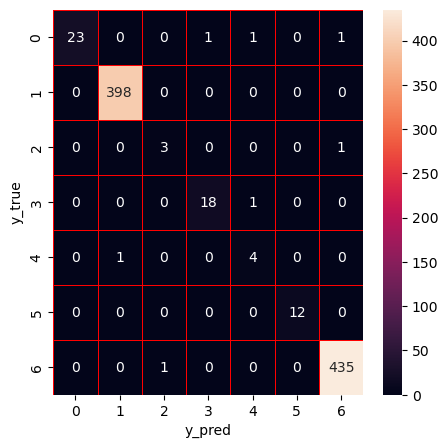

CPU times: user 7.12 s, sys: 1.91 s, total: 9.04 s
Wall time: 1.18 s


In [40]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 1412 to 2103
Data columns (total 77 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                900 non-null    float64
 1   Total Fwd Packets            900 non-null    float64
 2   Total Backward Packets       900 non-null    float64
 3   Total Length of Fwd Packets  900 non-null    float64
 4   Total Length of Bwd Packets  900 non-null    float64
 5   Fwd Packet Length Max        900 non-null    float64
 6   Fwd Packet Length Min        900 non-null    float64
 7   Fwd Packet Length Mean       900 non-null    float64
 8   Fwd Packet Length Std        900 non-null    float64
 9   Bwd Packet Length Max        900 non-null    float64
 10  Bwd Packet Length Min        900 non-null    float64
 11  Bwd Packet Length Mean       900 non-null    float64
 12  Bwd Packet Length Std        900 non-null    float64
 13  Flow Bytes/s         

# XGboost training

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           1       1.00      1.00      1.00       398
           2       1.00      0.75      0.86         4
           3       0.95      0.95      0.95        19
           4       0.57      0.80      0.67         5
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00       436

    accuracy                           0.99       900
   macro avg       0.93      0.91      0.91       900
weighted avg       0.99      0.99      0.99       900

Accuracy of XGBoost: 0.9922222222222222
Precision of XGBoost: 0.9931875350476647
Recall of XGBoost: 0.9922222222222222
Average F1 of XGBoost: 0.9923312819748108
F1 of XGBoost for each type of attack: [0.91666667 0.99874529 0.85714286 0.94736842 0.66666667 1.
 0.99771167]


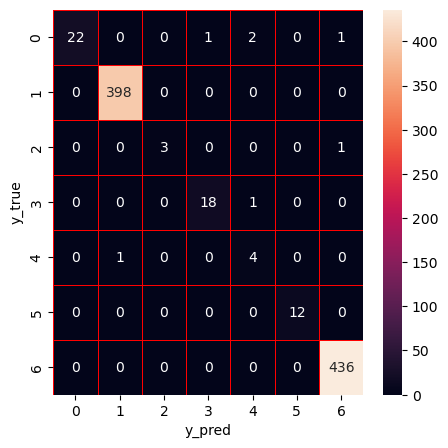

CPU times: user 4.05 s, sys: 1.15 s, total: 5.2 s
Wall time: 664 ms


In [42]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# CatBoost training

In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Proposed ensemble model: Leader Class and Confidence Decision Ensemble (LCCDE)

LCCDE aims to achieve optimal model performance by identifying the best-performing base ML model with the highest prediction confidence for each class. 

### Find the best-performing (leading) model for each type of attack among the three ML models

In [ ]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)

In [ ]:
model

**Leading Model for Each Type of Attack:**  
0 BENIGN: &emsp; XGBClassifier  
1 Bot:        &emsp;  &emsp;      XGBClassifier   
2 BruteForce:  &emsp;      LGBMClassifier  
3 DoS:        &emsp;   &emsp;   XGBClassifier  
4 Infiltration:  &emsp;       LGBMClassifier  
5 PortScan:  &emsp;       LGBMClassifier  
6 WebAttack:    &emsp;      XGBClassifier  

## LCCDE Prediction

In [ ]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1 
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2  
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3  

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence
                
                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3  
        
        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0]) 

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp


In [ ]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb)

# Performance of LCCDE model

In [ ]:
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

In [ ]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))

**Conclusion**: The performance (F1-score) of the proposed LCCDE ensemble model on each type of attack detection is higher than any base ML model.

In [ ]:
x_test_data=df

In [ ]:
x_test_data.head()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mode

def predict_with_confidence(x_test, m1, m2, m3):
    yp = [] # List to store final predictions

    for index, row in x_test.iterrows():
        # Convert row to numpy array for prediction
        xi = row.values.reshape(1, -1)
        
        # Get predictions from each model
        y_pred1 = m1.predict(xi)[0]
        y_pred2 = m2.predict(xi)[0]
        y_pred3 = m3.predict(xi)[0]

        # Get prediction probabilities (confidence) from each model
        p1 = np.max(m1.predict_proba(xi))
        p2 = np.max(m2.predict_proba(xi))
        p3 = np.max(m3.predict_proba(xi))

        # Decision logic for final prediction
        if y_pred1 == y_pred2 == y_pred3:
            y_pred = y_pred1
        elif y_pred1 == y_pred2:
            y_pred = y_pred1 if p1 >= p2 else y_pred2
        elif y_pred1 == y_pred3:
            y_pred = y_pred1 if p1 >= p3 else y_pred3
        elif y_pred2 == y_pred3:
            y_pred = y_pred2 if p2 >= p3 else y_pred3
        else:
            # If all predictions are different, choose the one with highest confidence
            preds = [(y_pred1, p1), (y_pred2, p2), (y_pred3, p3)]
            y_pred = max(preds, key=lambda x: x[1])[0]

        yp= y_pred

    return yp

In [ ]:
vehicle_type_mapping = {
    "BENIGN": 0,
    "DoS": 3,
    "WebAttack": 6,
    "Bot": 1,
    "PortScan": 5,
    "BruteForce": 2,
    "Infiltration": 4
}

In [ ]:
column_names = X_test.columns.tolist()

# Defining Properties For Simulation Window

In [ ]:
import pygame
import random
import csv

# Initialize Pygame
pygame.init()
prediction_logs = []

# Set up the game window
WINDOW_WIDTH = 800
WINDOW_HEIGHT = 600
window = pygame.display.set_mode((WINDOW_WIDTH, WINDOW_HEIGHT))
pygame.display.set_caption("Vehicle Intrusion Detection System")

# Define colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)

# Define colors for vehicle types
BENIGN_COLOR = GREEN
DOS_COLOR = (255, 0, 0)      # Red
WEBATTACK_COLOR = (255, 165, 0)  # Orange
BOT_COLOR = (255, 255, 0)     # Yellow
PORTSCAN_COLOR = (0, 255, 255)   # Cyan
BRUTEFORCE_COLOR = (255, 0, 255) # Magenta
INFILTRATION_COLOR = (128, 0, 128) # Purple

# Load car sprites
normal_car_sprite = pygame.image.load("/Users/dhruvmahalwar/Desktop/DESKTOP/Sem-6/NND/Intrusion Detection in IOV/cars_normal.png")
attack_car_sprite = pygame.image.load("/Users/dhruvmahalwar/Desktop/DESKTOP/Sem-6/NND/Intrusion Detection in IOV/cars_attack.png")

# Define vehicle classes
class Vehicle:
    def __init__(self, x, y, sprite, vehicle_type):
        self.x = x
        self.y = y
        self.sprite = sprite
        self.vehicle_type = vehicle_type

    def draw(self):
        window.blit(self.sprite, (self.x, self.y))

class BENIGNVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, normal_car_sprite, "BENIGN")

class DOSVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, attack_car_sprite, "DoS")

class WEBATTACKVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, attack_car_sprite, "WebAttack")

class BOTVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, attack_car_sprite, "Bot")

class PORTSCANVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, attack_car_sprite, "PortScan")

class BRUTEFORCEVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, attack_car_sprite, "BruteForce")

class INFILTRATIONVehicle(Vehicle):
    def __init__(self, x, y):
        super().__init__(x, y, attack_car_sprite, "Infiltration")



class IntrusionBot:
    def __init__(self, x, y):
        self.x, self.y = x, y

    def draw(self):
        pygame.draw.circle(window, BLACK, (self.x, self.y), 10)  # Draw as a dot
        font = pygame.font.Font(None, 24)
        text_surface = font.render('Intruder', True, BLACK)
        window.blit(text_surface, (self.x - 30, self.y + 20))  # Adjust text position as needed

    def send_packets(self, target_vehicle):
        pygame.draw.line(window, BLACK, (self.x, self.y), (target_vehicle.x + target_vehicle.sprite.get_width() // 2, target_vehicle.y + target_vehicle.sprite.get_height() // 2), 1)

# Initialize the intrusion bot at a safe location
intrusion_bot = IntrusionBot(WINDOW_WIDTH // 2, WINDOW_HEIGHT - 60)
# IDS models



# Packets Selection, Prediction And Creation of CSV file for Simulation Process

In [ ]:
def get_random_sample(vehicle_type, x_test_data):
    """
    Returns a random sample for the given vehicle type from x_test_data,
    with the last column (assumed to be 'Label') removed.
    """
    vehicle_type_int=vehicle_type_mapping[vehicle_type]
    filtered_samples = x_test_data[x_test_data['Label'] == vehicle_type_int]

    # Check if filtered_samples is empty
    if filtered_samples.empty:
        print("No samples found for this vehicle type.")
        return None

    # Drop the last column ('Label')
    samples_without_label = filtered_samples.drop(columns=['Label'])
    
    # Randomly select one sample
    random_index = np.random.randint(0, len(samples_without_label))
    random_sample = samples_without_label.iloc[random_index]
    
    # Convert to appropriate format if necessary, e.g., numpy array
    return random_sample


def lightgbm_model(vehicle, x_test_data):
    sample = get_random_sample(vehicle.vehicle_type, x_test_data)
    
    sample_df = pd.DataFrame([sample],columns=column_names)
    prediction = lg.predict(sample_df)
    return prediction[0]

def xgboost_model(vehicle, x_test_data):
    sample = get_random_sample(vehicle.vehicle_type, x_test_data)
    
    sample_df = pd.DataFrame([sample],columns=column_names)
    prediction = xg.predict(sample_df)
    return prediction[0]

def catboost_model(vehicle, x_test_data):
    sample = get_random_sample(vehicle.vehicle_type, x_test_data)
    
    sample_df = pd.DataFrame([sample],columns=column_names)
    prediction = cb.predict(sample_df)
    return prediction[0][0]

def lccde_model(vehicle, x_test_data):
    sample = get_random_sample(vehicle.vehicle_type, x_test_data)
    
    sample_df = pd.DataFrame([sample],columns=column_names)
    prediction = predict_with_confidence(sample_df, lg, xg, cb)
    return prediction

# Simulation Through PyGame

In [ ]:
# List to store vehicles
vehicles = []

# Game loop
running = True
while running:
    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        # Spawn new vehicles
        if event.type == pygame.KEYDOWN:
            x_position = random.randint(0, WINDOW_WIDTH - 50)
            # Adjust spawning to avoid the intruder's position
            while intrusion_bot.x - 50 < x_position < intrusion_bot.x + 50:
                x_position = random.randint(0, WINDOW_WIDTH - 50)

            vehicle_type = None
            if event.key == pygame.K_n:
                new_vehicle = BENIGNVehicle(x_position, 0)
                vehicle_type = "BENIGN"
            elif event.key == pygame.K_a:
                new_vehicle = DOSVehicle(x_position, 0)
                vehicle_type = "DoS"
            elif event.key == pygame.K_b:
                new_vehicle = WEBATTACKVehicle(x_position, 0)
                vehicle_type = "WebAttack"
            elif event.key == pygame.K_c:
                new_vehicle = BOTVehicle(x_position, 0)
                vehicle_type = "Bot"
            elif event.key == pygame.K_d:
                new_vehicle = PORTSCANVehicle(x_position, 0)
                vehicle_type = "PortScan"
            elif event.key == pygame.K_e:
                new_vehicle = BRUTEFORCEVehicle(x_position, 0)
                vehicle_type = "BruteForce"
            elif event.key == pygame.K_f:
                new_vehicle = INFILTRATIONVehicle(x_position, 0)
                vehicle_type = "Infiltration"

            if vehicle_type:
                vehicles.append(new_vehicle)

                # Simulate IDS model predictions
                lightgbm_prediction = lightgbm_model(new_vehicle, x_test_data)
                xgboost_prediction = xgboost_model(new_vehicle, x_test_data)
                catboost_prediction = catboost_model(new_vehicle, x_test_data)
                lccde_prediction = lccde_model(new_vehicle, x_test_data)
                prediction_data = {
                    'vehicle_type': vehicle_type_mapping[vehicle_type],
                    'lightgbm_prediction': lightgbm_prediction,
                    'xgboost_prediction': xgboost_prediction,
                    'catboost_prediction': catboost_prediction,
                    'lccde_prediction': lccde_prediction
                }
                prediction_logs.append(prediction_data)

    # Clear the window
    window.fill(WHITE)

    # Draw vehicles
    for vehicle in vehicles:
        vehicle.draw()

        # Display prediction results
        prediction_text = f"LightGBM: {lightgbm_prediction}, XGBoost: {xgboost_prediction}, CatBoost: {catboost_prediction}, LCCDE: {lccde_prediction}"
        text_surface = pygame.font.Font(None, 20).render(prediction_text, True, BLACK)
        window.blit(text_surface, (vehicle.x, vehicle.y + 50))

        # Highlight correct predictions
        # ... (existing code for highlighting predictions)

        # Move vehicles down (slow speed)
        vehicle.y += 1

        # Remove vehicles that go off-screen
        if vehicle.y > WINDOW_HEIGHT:
            vehicles.remove(vehicle)

        # Draw a line connecting the intruder bot and the vehicle
        if lccde_prediction:
            intrusion_bot.send_packets(vehicle)

    # Update the display
    intrusion_bot.draw()
    pygame.display.update()

# Quit Pygame
pygame.quit()


def save_predictions_to_csv(logs, filename="prediction_logs.csv"):
    fieldnames = ['vehicle_type', 'lightgbm_prediction', 'xgboost_prediction', 'catboost_prediction', 'lccde_prediction']
    with open(filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for log in logs:
            writer.writerow(log)

save_predictions_to_csv(prediction_logs)

# Simulation performance

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


data=pd.read_csv("prediction_logs.csv")
print(len(data))
# Extracting actual and predicted values
y_true = data['vehicle_type']
y_pred = data['lightgbm_prediction']


# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Displaying the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LightGBM Predictions')
plt.show()